In [1]:
# Copyright 2024 Keysight Technologies Inc.

In [2]:
import matplotlib.pyplot as plt
import trueq as tq
import trueq.simulation as tqs

# initiate a simulator
device = tq.Simulator()

# define time scales for single- and two-qubit gates
t_single_qb_gate = 50e-9
# 50 ns single-qubit gates
t_entangling_gate = 450e-9
# 450 ns entangling gates

# define time scales for relaxation processes
t1 = 100e-6  # 100 us population relaxation time
t2 = 100e-6  # 100 us phase relaxation time

# add a relaxation noise source based on the time scales above
device.add_relaxation(
    t1=t1, t2=t2, t_single=t_single_qb_gate, t_multi=t_entangling_gate
)

# define matches for introducing entangling operations with different fidelities
entangler_01_match = tqs.LabelMatch((0, 1)) & tqs.GateMatch(tq.Gate.cx)
entangler_12_match = tqs.LabelMatch((1, 2)) & tqs.GateMatch(tq.Gate.cx)

# add different unitary overrotation noise sources depending on the entangler
device.add_overrotation(multi_sys=0.12, match=entangler_01_match)
device.add_overrotation(multi_sys=0.08, match=entangler_12_match)

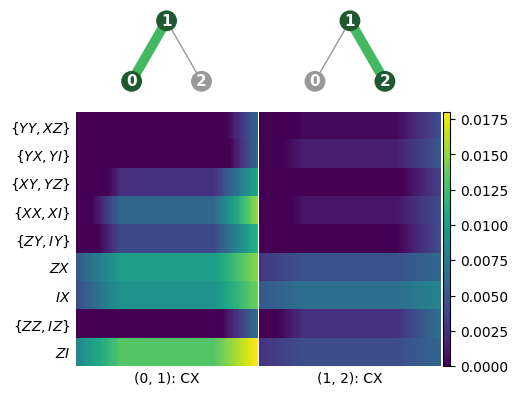

In [3]:
# define the twirl over all three qubits to ensure thorough diagnostics
twirl = tq.Twirl("P", (0, 1, 2))

# define the cycles of interest for the diagnostics
cycle1 = tq.Cycle({(0, 1): tq.Gate.cx})
cycle2 = tq.Cycle({(1, 2): tq.Gate.cx})

# initialize a circuit collection with KNR circuits to characterize each hard cycle
knr_circuits = tq.make_knr(
    cycle1, n_random_cycles=[4, 16, 24], n_circuits=30, subsystems=1, twirl=twirl
)
knr_circuits += tq.make_knr(
    cycle2, n_random_cycles=[4, 24, 32], n_circuits=30, subsystems=1, twirl=twirl
)

# run the circuits on our device
device.run(knr_circuits, n_shots=1e4)

# plot the error profile:
layout = tq.visualization.Graph.linear(3, show_labels=True)  # specify the chip layout
knr_circuits.plot.knr_heatmap(layout)  # plot the heatmap

In [4]:
emulator = tq.Simulator().add_knr_noise(knr_circuits)

In [5]:
cycle0 = tq.Cycle({0: tq.Gate.h})
circuit = tq.Circuit([cycle0, cycle1, cycle2])
circuit.measure_all()
circuit.draw()

DisplayWrapper(<svg xmlns="http://w...)

In [6]:
# randomly compile the test circuit
rc_circuits = tq.randomly_compile(circuit, n_compilations=30)

# sample the randomly compiled versions of the circuit on the device
device_results = sum(
    device.sample(rc_circuit, n_shots=1e3) for rc_circuit in rc_circuits
)

# sample the randomly compiled versions of the circuit on the emulator
emulator_results = sum(
    emulator.sample(rc_circuit, n_shots=1e3) for rc_circuit in rc_circuits
)

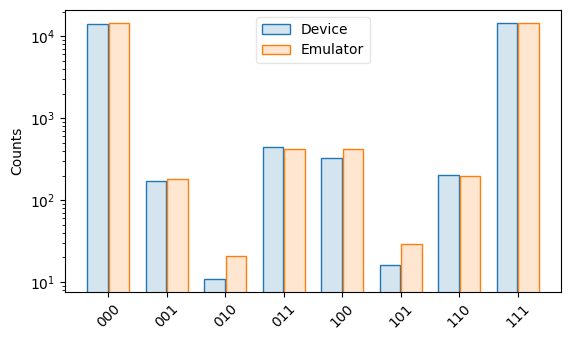

In [7]:
tq.visualization.plot_results(
    device_results, emulator_results, labels=["Device", "Emulator"]
)

plt.gca().set_yscale("log")